In [105]:
import pandas as pd
import matplotlib.pyplot as plt

from neo4j import GraphDatabase
import logging
from neo4j.exceptions import ServiceUnavailable
from graphdatascience import GraphDataScience

In [106]:
class Neo4jConnection:

    URI = "bolt://localhost:7687"
    USER = "neo4j"
    PWD = "12345678"
    
    def __init__(self):
        self.__uri = Neo4jConnection.URI
        self.__user = Neo4jConnection.USER
        self.__pwd = Neo4jConnection.PWD
        self.__driver = None
        try:
            self.__driver = GraphDatabase.driver(self.__uri, auth=(self.__user, self.__pwd))
        except Exception as e:
            print("Failed to create the driver:", e)
        
    def close(self):
        if self.__driver is not None:
            self.__driver.close()
        
    def query(self, query, parameters=None, db=None):
        assert self.__driver is not None, "Driver not initialized!"
        session = None
        response = None
        try: 
            session = self.__driver.session(database=db) if db is not None else self.__driver.session() 
            response = list(session.run(query, parameters))
        except Exception as e:
            print("Query failed:", e)
        finally: 
            if session is not None:
                session.close()
        return response


def get_graph_db():
    """
    
    
    """
    # credentials
    uri = "bolt://localhost:7687"
    user = "neo4j"
    password = "12345678"
    database_name = 'neo4j'
    graph_name = 'frontiers'

    # creates the connection
    gds = GraphDataScience(uri, auth=(user, password), database=database_name)
    
    # project the graph
    G, _ = gds.graph.project(graph_name, # graph name
                                ['Author', 'Publication', 'Topic'], # node labels
                                ['WRITES', 'IS_ABOUT'], # relationships
                            )

    return gds, G, graph_name


def get_centrality_scores(algorithm):
    """
    
    
    """

    # get connection
    gds, G, graph_name = get_graph_db()

    if algorithm == 'degree':
        # get algorithm scores
        scores = gds.degree.stream(G)
    
    if algorithm == 'betweenness':
        # get algorithm scores
        scores = gds.betweenness.stream(G)

    if algorithm == 'eigenvector':
        # get algorithm scores
        scores = gds.eigenvector.stream(G)

    if algorithm == 'pageRank':
        # get algorithm scores
        scores = gds.pageRank.stream(G)
    
    # get nodes details
    nodes = pd.DataFrame(gds.util.asNodes(list(scores.nodeId)))

    # merge scores and nodes details
    nodes_scores = nodes.join(scores).dropna(subset=['author_id'])

    # drop unnedeed columns
    nodes_scores.drop(labels=['doi',
                                'name',
                                'publication_id',
                                'publication_year',
                                'status',
                                'topic_id',
                                'nodeId'
                            ], axis=1, inplace=True)


    # drop the graph
    gds.graph.drop(gds.graph.get(graph_name))
    
    # close the connection
    gds.close()

    # return results with scores in decending order
    return nodes_scores.sort_values(by='score', ascending=False)

In [107]:
# get scores using 'betweenness' algorithm
betweenness_scores = get_centrality_scores('betweenness')
betweenness_scores

,author_id,full_name,h_index,research_sector,score
0,309238221625,Guillaume Lemaître,10.0,32057259,0.0
243,472446930578,Kazuhiko Hara,53.0,1631149,0.0
252,1331440430846,Andreas J. H. Reiter,4.0,17040978,0.0
251,17180417396,M. Redchuk,8.0,23376214,0.0
250,1391569982571,S. Kamada,9.0,1631149,0.0
...,...,...,...,...,...
121,206159056594,Lukoye Atwoli,24.0,7352532,0.0
120,197568999945,K. Matsui,9.0,27313889,0.0
119,60130093551,R. Massarczyk,19.0,30262949,0.0
118,1305670667369,M. Mikestikova,66.0,1631149,0.0


In [108]:
# get scores using 'eigenvector' algorithm
eigenvector_scores = get_centrality_scores('eigenvector')
eigenvector_scores

,author_id,full_name,h_index,research_sector,score
0,309238221625,Guillaume Lemaître,10.0,32057259,2.655296e-08
243,472446930578,Kazuhiko Hara,53.0,1631149,2.655296e-08
252,1331440430846,Andreas J. H. Reiter,4.0,17040978,2.655296e-08
251,17180417396,M. Redchuk,8.0,23376214,2.655296e-08
250,1391569982571,S. Kamada,9.0,1631149,2.655296e-08
...,...,...,...,...,...
121,206159056594,Lukoye Atwoli,24.0,7352532,2.655296e-08
120,197568999945,K. Matsui,9.0,27313889,2.655296e-08
119,60130093551,R. Massarczyk,19.0,30262949,2.655296e-08
118,1305670667369,M. Mikestikova,66.0,1631149,2.655296e-08


In [109]:
# get scores using 'pageRank' algorithm
pagerank_scores = get_centrality_scores('pageRank')
pagerank_scores

,author_id,full_name,h_index,research_sector,score
0,309238221625,Guillaume Lemaître,10.0,32057259,0.15
243,472446930578,Kazuhiko Hara,53.0,1631149,0.15
252,1331440430846,Andreas J. H. Reiter,4.0,17040978,0.15
251,17180417396,M. Redchuk,8.0,23376214,0.15
250,1391569982571,S. Kamada,9.0,1631149,0.15
...,...,...,...,...,...
121,206159056594,Lukoye Atwoli,24.0,7352532,0.15
120,197568999945,K. Matsui,9.0,27313889,0.15
119,60130093551,R. Massarczyk,19.0,30262949,0.15
118,1305670667369,M. Mikestikova,66.0,1631149,0.15


In [110]:
# get scores using 'degree' algorithm
degree_scores = get_centrality_scores('degree')
degree_scores

,author_id,full_name,h_index,research_sector,score
167,42949672963,Carlos Augusto Monteiro,77.0,7352532,186.0
188,532576531850,Damián Vázquez,5.0,7352532,186.0
5,386547616079,Kirsten Patrick,11.0,7352532,186.0
121,206159056594,Lukoye Atwoli,24.0,7352532,185.0
343,309238158932,Garth M. Huber,36.0,17040978,40.0
...,...,...,...,...,...
306,747324828509,Douglas Murad,3.0,32057259,1.0
216,77310035272,Mariano Masiokas,27.0,1631149,1.0
103,17180459373,Moisés Rojas-Badilla,5.0,1631149,1.0
100,781684685480,Julien Champ,10.0,32057259,1.0


        author_id                full_name  h_index research_sector  score
167   42949672963  Carlos Augusto Monteiro     77.0         7352532  186.0
188  532576531850           Damián Vázquez      5.0         7352532  186.0
5    386547616079          Kirsten Patrick     11.0         7352532  186.0
121  206159056594            Lukoye Atwoli     24.0         7352532  185.0


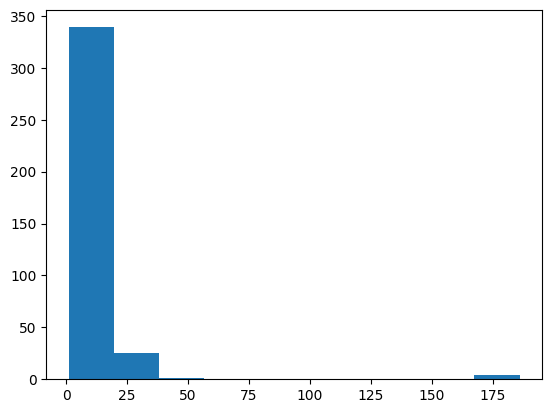

In [111]:
# plot histogram and depicts the more influential ones
plt.hist(degree_scores.score)
print(degree_scores[degree_scores.score > 150])

In [112]:
def create_author_topic_link(conn):
    """
    
    
    """
    query = """
            MATCH (a)-[WRITES]->(p)-[IS_ABOUT]->(t)
            WITH a,t
            MERGE (a)-[:WORKS_IN]-(t)
            
            RETURN count(*) as total
            """
    
    return conn.query(query)


def get_reviewers(conn, publication_id):
    """
    
    
    """
    query = '''
            MATCH (a)-[:WORKS_IN]->(t)<-[IS_ABOUT]-(p)
            WHERE p.publication_id = $pub_id AND NOT ((a)-[:WRITES]->(p))
            
            RETURN a.author_id AS author_id, a.full_name AS full_name, a.research_sector AS research_sector
            '''
    
    return pd.DataFrame([dict(_) for _ in conn.query(query, parameters = {'pub_id':publication_id})])

In [113]:
# get a connection to the database
conn = Neo4jConnection()

# creates the links between authors and topics
create_author_topic_link(conn)

# get a list of suggeste reviewers for a given incomming publication
reviewers = get_reviewers(conn, '94489832576')
reviewers

,author_id,full_name,research_sector
0,163209302931,Flávia A. Maia,3030287
1,489626818966,Luca D'Auria,17040978
2,1005022913578,Marinã R. Amaral,3030287
3,326418070679,Christopher Baethge,7352532
4,206158957580,Marcello Martini,17040978
5,489626845741,Silmara A. Diniz,3030287
6,635655697657,Astrid James,7352532
7,240518737946,Laragh Gollogly,7352532
8,163209322942,Frank A. Frizelle,7352532
9,360777873683,F. Giudicepietro,17040978
